In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/walmart-sales-forecast/features.csv
/kaggle/input/walmart-sales-forecast/stores.csv
/kaggle/input/walmart-sales-forecast/train.csv
/kaggle/input/walmart-sales-forecast/test.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
%matplotlib inline

In [3]:
# Installing pyspark
!pip install pyspark
import pyspark.sql.functions as f
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Time Series analysis').getOrCreate()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.6 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425350 sha256=dab4475f4882e0b18c80e44fe49e1b1264f5a7f0fc070efa8ab7ff574f6ae17b
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/07 13:05:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
!pip install xgboost

## Joining Datasets and Creating features

In [5]:
df = spark.read.options(delimeter=',', inferSchema=True, header=True).csv('/kaggle/input/walmart-sales-forecast/train.csv')
stores = spark.read.options(delimeter=',', inferSchema=True, header=True).csv('/kaggle/input/walmart-sales-forecast/stores.csv')
features = spark.read.options(delimeter=',', inferSchema=True, header=True).csv('/kaggle/input/walmart-sales-forecast/features.csv')
# Converting 'NA' strings in MarkDown columns to null values
for i in range(1,6):
    features = features.withColumn(
        f'MarkDown{i}', f.when(f.col(f'MarkDown{i}')=='NA', None).otherwise(
            f.col(f'MarkDown{i}')).cast('float'))
pdf = df.join(
    stores, on='Store', how='inner').join(
    features.drop('IsHoliday'), on=['Date','Store'], how='left').toPandas()
pdf['Date'] = pd.to_datetime(pdf['Date'])
pdf.set_index('Date', inplace=True)
pdf["CPI"] = pd.to_numeric(pdf["CPI"], downcast="float")
pdf["Unemployment"] = pd.to_numeric(pdf["Unemployment"], downcast="float")
pdf['Day'] = pdf.index.day
pdf['Week'] = np.ceil(pdf.index.dayofyear/7).astype(int)
pdf['Month'] = pdf.index.month
pdf['Quarter'] = pdf.index.quarter
pdf['Year'] = pdf.index.year
pdf = pdf.query('Weekly_Sales >= 0 and Weekly_Sales < 200000')
pdf.head().style.hide(axis="index")

Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Day,Week,Month,Quarter,Year
1,1,24924.500000,False,A,151315,42.310000,2.572000,nan,nan,nan,nan,nan,211.096359,8.106000,5,6,2,1,2010
1,1,46039.490000,True,A,151315,38.510000,2.548000,nan,nan,nan,nan,nan,211.242172,8.106000,12,7,2,1,2010
1,1,41595.550000,False,A,151315,39.930000,2.514000,nan,nan,nan,nan,nan,211.289139,8.106000,19,8,2,1,2010
1,1,19403.540000,False,A,151315,46.630000,2.561000,nan,nan,nan,nan,nan,211.319641,8.106000,26,9,2,1,2010
1,1,21827.900000,False,A,151315,46.500000,2.625000,nan,nan,nan,nan,nan,211.350143,8.106000,5,10,3,1,2010


## Handling Missing values

In [9]:
pdf.isnull().sum()

Store                0
Dept                 0
Weekly_Sales         0
IsHoliday            0
Type                 0
Size                 0
Temperature          0
Fuel_Price           0
MarkDown1       269992
MarkDown2       309270
MarkDown3       283525
MarkDown4       285656
MarkDown5       269244
CPI                  0
Unemployment         0
Day                  0
Week                 0
Month                0
Quarter              0
Year                 0
dtype: int64

- **Only MarkDown columns have missing values.**  
- As they are anonimized offer related sales. We can assume if there is no data (NaN) for a particular day then the value is 0.  
- So we can replace nulls with 0.  

In [6]:
pdf.fillna(0, inplace=True)

## Converting String / Boolean Columns into Numerical

In [7]:
# Converting Is Holiday column to int
# Changing the type will replace True -> 1 and False -> 0
pdf['IsHoliday'] = pdf['IsHoliday'].astype('int')

In [8]:
# Converting Type of store into numerical
# We will use the order of size to decide the numerical values for store types
# As we have seen Type A stores are largest and C are smallest, 
# we will use the following mapping
# C-> 0, B-> 1, A-> 2

pdf['Type'] = pdf['Type'].replace({'C': 0, 'B': 1, 'A': 2})

## Model

In [13]:
TARGET = ['Weekly_Sales']
FEATURES = [i for i in pdf.columns if i not in TARGET]

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(pdf[FEATURES], pdf[TARGET],
                                                   test_size=0.2, random_state=130)

In [15]:
import xgboost as xgb

In [16]:
reg = xgb.XGBRegressor(n_estimators=2000, early_stopping_rounds=50,
                      learning_rate=0.5)
model = reg.fit(X_train, y_train,
       eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=100)

[0]	validation_0-rmse:17044.62216	validation_1-rmse:17109.87108
[100]	validation_0-rmse:4349.84165	validation_1-rmse:4597.27229
[200]	validation_0-rmse:3577.32971	validation_1-rmse:3987.28729
[300]	validation_0-rmse:3115.14008	validation_1-rmse:3649.98285
[400]	validation_0-rmse:2846.67648	validation_1-rmse:3472.11574
[500]	validation_0-rmse:2653.89408	validation_1-rmse:3360.84110
[600]	validation_0-rmse:2505.90575	validation_1-rmse:3283.48677
[700]	validation_0-rmse:2378.48804	validation_1-rmse:3222.97227
[800]	validation_0-rmse:2265.82434	validation_1-rmse:3170.98844
[900]	validation_0-rmse:2171.00411	validation_1-rmse:3128.74889
[1000]	validation_0-rmse:2087.53261	validation_1-rmse:3098.41834
[1100]	validation_0-rmse:2020.10582	validation_1-rmse:3072.71828
[1200]	validation_0-rmse:1946.50122	validation_1-rmse:3040.49498
[1300]	validation_0-rmse:1885.91482	validation_1-rmse:3019.60172
[1400]	validation_0-rmse:1834.96139	validation_1-rmse:3003.86225
[1500]	validation_0-rmse:1781.04385

In [23]:
y_pred = reg.predict(X_test)

In [33]:
xgboost_accuracy = reg.score(X_test,y_test)*100
print("XGB Regressor Evaluation Metrics: ")
print("Accuracy", round(xgboost_accuracy,3))
print("MAE \t" , round(metrics.mean_absolute_error(y_test, y_pred),3))
print("MSE \t" , round(metrics.mean_squared_error(y_test, y_pred),3))
print("RMSE \t" , round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),3))
print("R2 \t" , round(metrics.explained_variance_score(y_test, y_pred),5))

XGB Regressor Evaluation Metrics: 
Accuracy 98.249
MAE 	 1614.997
MSE 	 8623842.392
RMSE 	 2936.638
R2 	 0.98249


In [17]:
print('Top 10 features with their Feature importance scores: ')
pd.DataFrame(data=reg.feature_importances_,
            index=reg.feature_names_in_,
            columns=['Feature Importance']).sort_values('Feature Importance', ascending=False).head(10)

Top 10 features with their Feature importance scores: 


,Feature Importance
Size,0.358337
Dept,0.189229
Type,0.140156
Store,0.090434
Month,0.047744
CPI,0.034066
Week,0.031394
IsHoliday,0.028932
Year,0.018525
Unemployment,0.014832


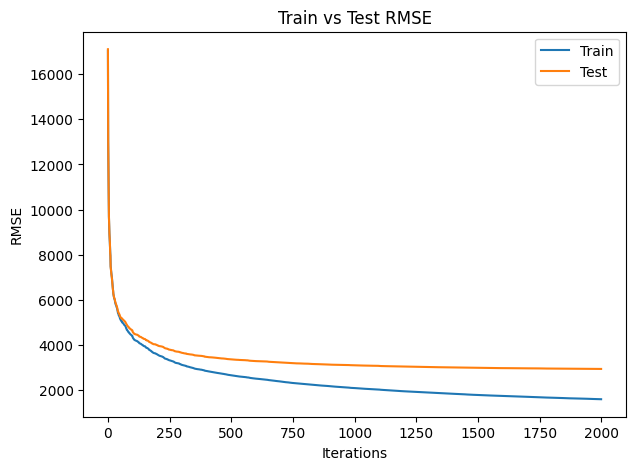

In [18]:
fig, ax = plt.subplots(1,1,figsize=(7,5))
score_hist = pd.DataFrame({'Train_rmse':model.evals_result()['validation_0']['rmse'], 'Test_rmse':model.evals_result()['validation_1']['rmse']})
sns.lineplot(score_hist['Train_rmse'], ax=ax, label='Train')
sns.lineplot(score_hist['Test_rmse'], ax=ax, label='Test')
plt.ylabel('RMSE')
plt.xlabel('Iterations')
plt.title('Train vs Test RMSE')
plt.show()

In [ ]:
val = pdf.loc[pdf.index >= '2012-05-01']
X_val, y_val = val[FEATURES], val[TARGET]
val['prediction'] = reg.predict(X_val)

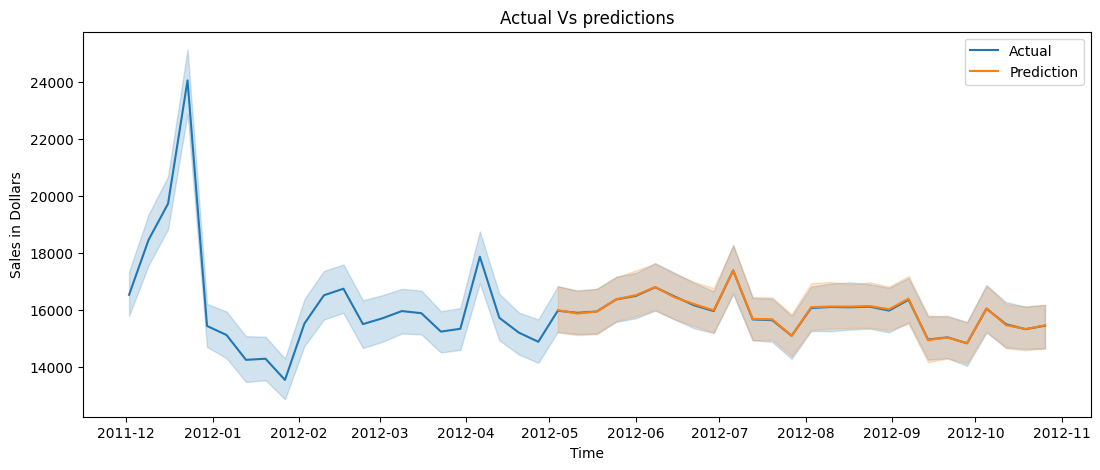

In [20]:
fig, ax = plt.subplots(1,1,figsize=(13,5))
sns.lineplot(pdf['Weekly_Sales'].loc[pdf.index>'2011-12-01'], ax=ax, label='Actual')
sns.lineplot(val['prediction'], ax=ax, label='Prediction')
plt.ylabel('Sales in Dollars')
plt.xlabel('Time')
plt.title('Actual Vs predictions')
plt.show()

The Predictions are pretty close to the actual values as we have a **accuracy of 98%**

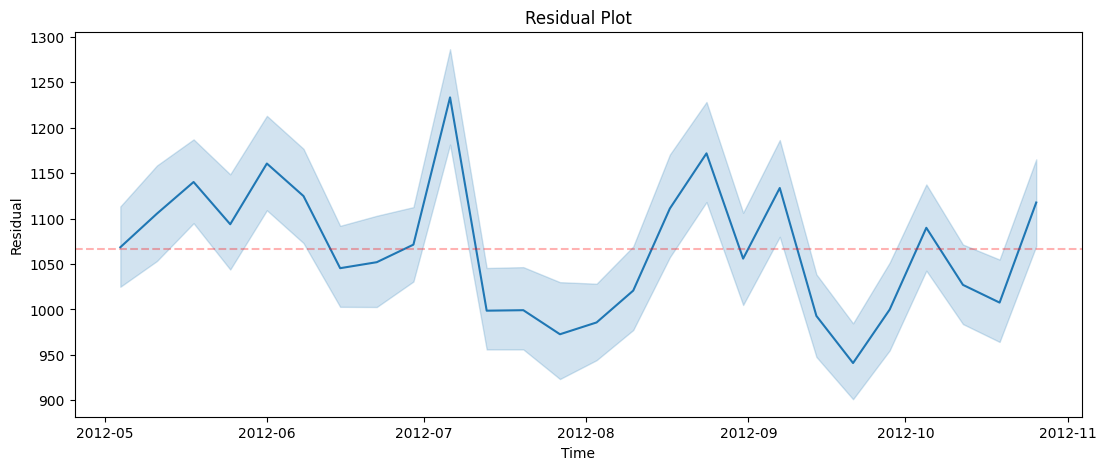

In [35]:
val = val.assign(Residual= abs(val['Weekly_Sales'] - val['prediction']))
fig, ax = plt.subplots(1,1,figsize=(13,5))
#sns.lineplot(pdf['Weekly_Sales'].loc[pdf.index>'2011-12-01'], ax=ax, label='Actual')
sns.lineplot(val['Residual'], ax=ax)
plt.axhline(val['Residual'].mean(), linestyle='--', color='r', alpha=0.3)
#plt.ylabel('Sales in Dollars')
plt.xlabel('Time')
plt.title('Residual Plot')
plt.show()

The residuals are close to the MAE

## Predicting Overall sales per day using SARIMA / GARCH / VAR models

#### Preparing Dataset (cumulating sales for all stores)

In [9]:
cum_pdf = pdf['Weekly_Sales'].groupby('Date').sum().to_frame(name='Weekly_Sales')

In [10]:
train = cum_pdf.loc[cum_pdf.index < '2012-05-01']
test = cum_pdf.loc[cum_pdf.index >= '2012-05-01']

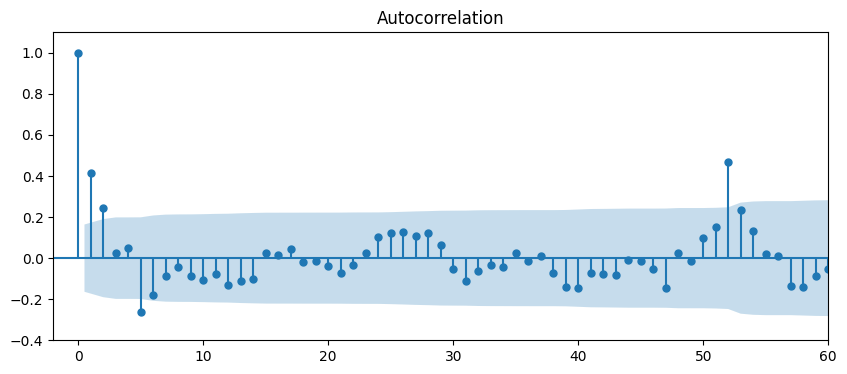

In [69]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(figsize=(10,4))
acf_plot = plot_acf(cum_pdf.Weekly_Sales, lags=100, ax=ax)
plt.ylim(-0.4, 1.1)
plt.xlim(-2,60)
plt.show()

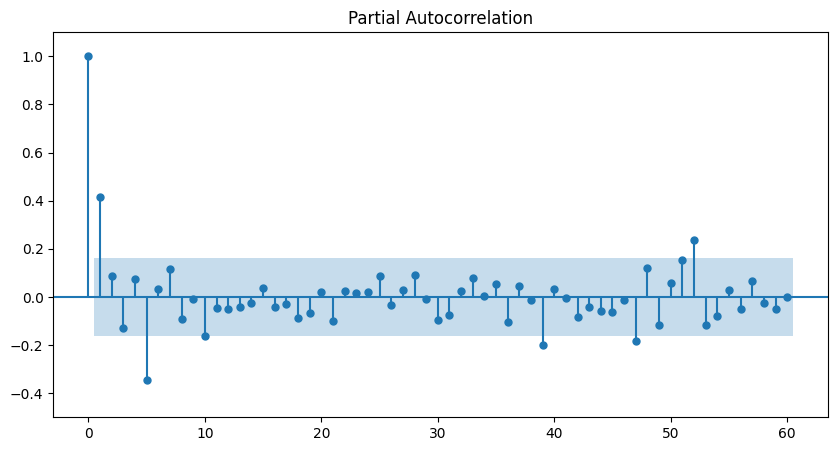

In [70]:
fig, ax = plt.subplots(figsize=(10,5))
pacf_plot = plot_pacf(cum_pdf.Weekly_Sales, lags=60, ax=ax)
plt.ylim(-0.5, 1.1)
plt.show()

In [71]:
from statsmodels.tsa.stattools import adfuller
ADF_result = adfuller(cum_pdf.Weekly_Sales)   
print(f'ADF Statistic: {ADF_result[0]}') 
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -6.357042012534244
p-value: 2.527814798229619e-08


As the p-value is less than 0.05 and ADF statistic is a negative number  
**The Time series is Stationary**

In [ ]:
import statsmodels.api as sm
order_aic_bic =[]

# Loop over p values from 0-2
for p in [1,2,5,52]:
    # Loop over q values from 0-2
    for q in [1,2,5,52]:
      
        try:
            # create and fit ARMA(p,q) model
            model = sm.tsa.statespace.SARIMAX(train.Weekly_Sales, order=(p, 0, q))
            results = model.fit(maxiter=100, full_output=False, disp=False)
            
            # Print order and results
            order_aic_bic.append((p, q, results.aic, results.bic))            
        except:
            print(p, q, None, None)
            
# Make DataFrame of model order and AIC/BIC scores
order_df = pd.DataFrame(order_aic_bic, columns=['p', 'q', 'aic','bic'])

In [77]:
# lets sort them by AIC and BIC

# Sort by AIC
print("Sorted by AIC ")
print("\n")
print(order_df.sort_values('aic').reset_index(drop=True))

# Sort by BIC
print("Sorted by BIC ")
print("\n")
print(order_df.sort_values('bic').reset_index(drop=True))

Sorted by AIC 


     p   q          aic          bic
0   52   5  3879.271281  4039.477369
1   52   2  3882.572409  4034.491975
2   52   1  3882.608620  4031.766013
3    1   5  3920.531866  3939.867084
4    5   5  3925.789982  3956.173895
5    2   1  3930.915414  3941.964110
6    1   2  3937.795438  3948.844134
7    5   2  3939.889030  3961.986422
8    5   1  3942.014748  3961.349966
9    1   1  3942.865561  3951.152083
10   2   2  3945.281683  3959.092553
11   2   5  3972.345789  3994.443180
12   1  52  3981.262006  4130.419398
13   2  52  3982.787185  4134.706752
14   5  52  4001.086178  4161.292266
15  52  52  4060.930503  4350.958766
Sorted by BIC 


     p   q          aic          bic
0    1   5  3920.531866  3939.867084
1    2   1  3930.915414  3941.964110
2    1   2  3937.795438  3948.844134
3    1   1  3942.865561  3951.152083
4    5   5  3925.789982  3956.173895
5    2   2  3945.281683  3959.092553
6    5   1  3942.014748  3961.349966
7    5   2  3939.889030  3961.986422
8   

p = 1 and q = 5 gives the lowest bic &  
p = 52 and q = 5 gives the lowest aic

In [30]:
# The model with the best p and q found from pervious step
import statsmodels.api as sm
model = sm.tsa.statespace.SARIMAX(train.Weekly_Sales, order=(52, 0, 5))
# Fit model
results = model.fit()
# Assign residuals to variable
residuals = results.resid

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           58     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.72251D+02    |proj g|=  8.98967D+02

At iterate    5    f=  2.19392D+01    |proj g|=  4.95784D+00

At iterate   10    f=  1.67367D+01    |proj g|=  1.15253D+00

At iterate   15    f=  1.62973D+01    |proj g|=  3.05497D-01

At iterate   20    f=  1.62719D+01    |proj g|=  8.10797D-02

At iterate   25    f=  1.62507D+01    |proj g|=  1.37814D-01

At iterate   30    f=  1.62038D+01    |proj g|=  3.14070D-01

At iterate   35    f=  1.61689D+01    |proj g|=  6.97579D-02

At iterate   40    f=  1.61619D+01    |proj g|=  6.28076D-02

At iterate   45    f=  1.61510D+01    |proj g|=  6.75332D-02

At iterate   50    f=  1.61391D+01    |proj g|=  1.24810D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [31]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  117
Model:              SARIMAX(52, 0, 5)   Log Likelihood               -1888.280
Date:                Tue, 07 Nov 2023   AIC                           3892.560
Time:                        13:38:05   BIC                           4052.766
Sample:                    02-05-2010   HQIC                          3957.602
                         - 04-27-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0092      0.115      0.080      0.936      -0.216       0.234
ar.L2          0.0335      0.104      0.321      0.748      -0.171       0.238
ar.L3         -0.0219      0.102     -0.215      0.830      -0.221       0.178
ar.L4         -0.0246      0.112     -0.220      0.826      -0.244       0.195
ar.L5         -0.0196      0.067     -0.292      0.771      -0.151       0.112
ar.L6         -0.0907      0.078     -1.164      0.245      -0.243       0.062
ar.L7          0.0902      0.079      1.144      0.253      -0.064       0.245
ar.L8         -0.0354      0.095     -0.371      0.711      -0.222       0.152
ar.L9         -0.0663      0.089     -0.744      0.457      -0.241       0.108
ar.L10         0.0414      0.080      0.520      0.603      -0.115       0.197
ar.L11        -0.0521      0.073     -0.715      0.474      -0.195       0.091
ar.L12         0.0872      0.089      0.983      0.326      -0.087       0.261
ar.L13        -0.0090      0.075     -0.119      0.905      -0.156       0.138
ar.L14        -0.1023      0.088     -1.164      0.244      -0.275       0.070
ar.L15         0.1069      0.072      1.485      0.137      -0.034       0.248
ar.L16         0.0339      0.075      0.454      0.650      -0.112       0.180
ar.L17         0.0284      0.076      0.376      0.707      -0.120       0.177
ar.L18         0.0061      0.058      0.104      0.917      -0.108       0.120
ar.L19        -0.0273      0.083     -0.330      0.742      -0.189       0.135
ar.L20         0.0452      0.089      0.509      0.611      -0.129       0.219
ar.L21        -0.0326      0.101     -0.321      0.748      -0.231       0.166
ar.L22        -0.0096      0.098     -0.097      0.922      -0.202       0.183
ar.L23         0.0223      0.101      0.221      0.825      -0.175       0.219
ar.L24         0.0124      0.126      0.099      0.921      -0.234       0.259
ar.L25         0.0776      0.117      0.662      0.508      -0.152       0.308
ar.L26        -0.0113      0.086     -0.131      0.896      -0.180       0.157
ar.L27        -0.0139      0.120     -0.115      0.908      -0.249       0.222
ar.L28         0.0688      0.100      0.690      0.490      -0.127       0.264
ar.L29         0.0144      0.110      0.130      0.896      -0.202       0.231
ar.L30         0.0157      0.101      0.156      0.876      -0.181       0.213
ar.L31        -0.0121      0.079     -0.152      0.879      -0.167       0.143
ar.L32         0.0137      0.104      0.132      0.895      -0.190       0.217
ar.L33         0.0859      0.099      0.866      0.387      -0.109       0.280
ar.L34        -0.0359      0.089     -0.403      0.687      -0.211       0.139
ar.L35        -0.0089      0.097     -0.091      0.927      -0.199       0.181
ar.L36        -0.0016      0.092     -0.018      0.986      -0.182       0.179
ar.L37        -0.0385      0.084     -0.456      0.648      -0.204       0.127
ar.L38         0.1340      0.107      1.252      0.211      -0.076       0.344
ar

In [32]:
# The mean absolute error
mae = np.mean(np.abs(residuals))
print("Mean Absolute Error: ", mae)

Mean Absolute Error:  2171004.43794748


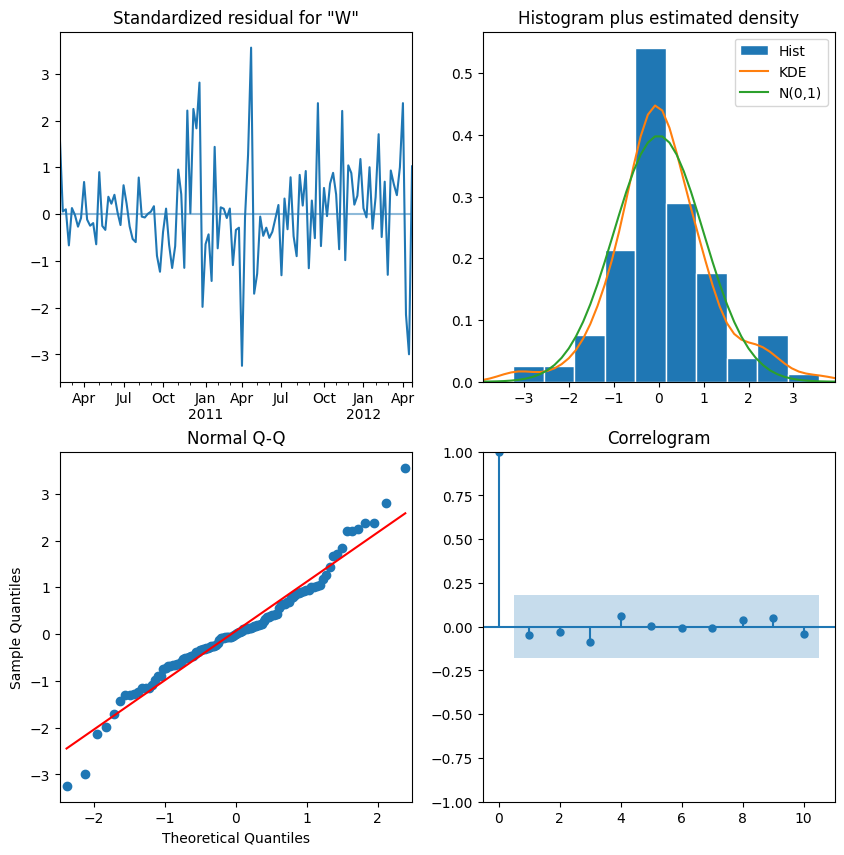

In [33]:
results.plot_diagnostics(figsize=(10,10))
plt.show()

**Standardized residuals plot:** The top left plot shows one-step-ahead standardized residuals. If our model is working correctly, there should be no obvious pattern in the residuals. This is shown here in this case.  
**Histogram plus estimated density plot:** This plot shows the distribution of the residuals. The histogram shows us the measured distribution; the orange line shows a smoothed version of this histogram, and the green line shows a normal distribution. If the model is good these two lines should be the same. Here there are little differences between them, which indicate that our model is doing great.  
**Normal Q-Q plot:** The Q-Q plot compare the distribution of the residuals to the normal distribution. If the distribution of the residuals is normal, then all the points should lie along the red line, except for some values at the end.  
**Correlogram plot:** The correlogram plot is the ACF plot of the residuals rather than the data. 95% of the correlations for lag greater than zero should not be significant (within the blue shades). If there is a significant correlation in the residuals, it means that there is information in the data that was not captured by the model.

In [34]:
#get the predictions and residuals
predictions = results.forecast(len(test))
predictions = pd.Series(predictions, index=test.index).to_frame(name='Weekly_Sales')
residuals = test - predictions

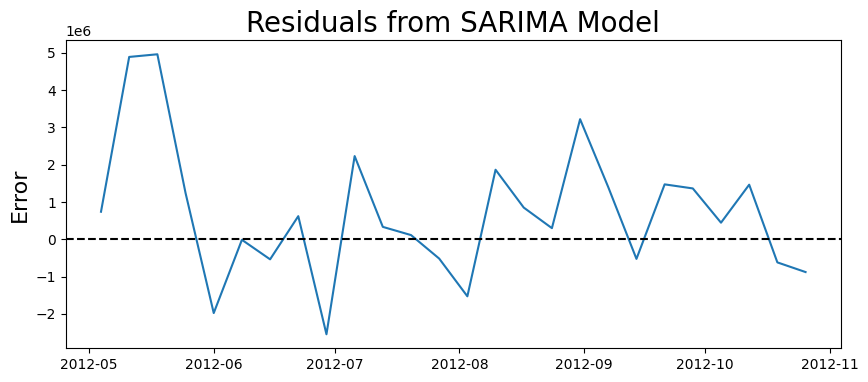

In [39]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title( 'Residuals from SARIMA Model' ,fontsize=20)
plt.ylabel( 'Error', fontsize=16)
plt.show()

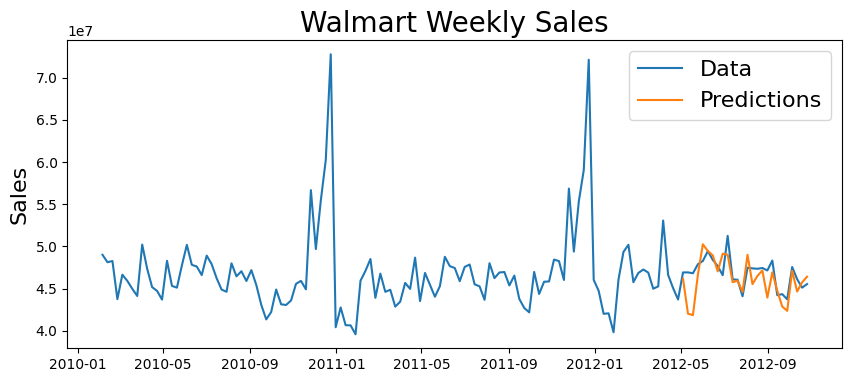

In [41]:
plt.figure(figsize=(10,4))
plt.plot(cum_pdf)
plt.plot(predictions)

plt.legend(('Data','Predictions'), fontsize=16)

plt.title('Walmart Weekly Sales', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.show()

In [43]:
print('MAPE: ', round(np.mean(abs(residuals/test)),4))
print('Root Mean Squared Error: ', round(np.sqrt(np.mean(residuals**2)),2))

MAPE:  0.03
Root Mean Squared Error:  1898234.53
